In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM 
from keras.utils import plot_model, multi_gpu_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

Using TensorFlow backend.


In [30]:
sns.set_style("whitegrid")
np.random.seed(0)

DATA_PATH = ''
EMBEDDING_PATH = './wiki.en.vec'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])


In [3]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_PATH, encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

1287it [00:00, 6432.00it/s]

loading word embeddings...


2519428it [04:46, 8797.08it/s]

found 2519396 word vectors


In [4]:
import xlrd

#输入文件路径，返回list;list内包含n个字典形式数据集
def read_xlsx(path):
    book = xlrd.open_workbook(path)
    first_sheet = book.sheet_by_index(0)
    result = []
    index = 0
    #print(first_sheet.row_values(3))
    key = first_sheet.row_values(index)
    print('key = ',key)
    index += 1
    while(1):
        try:
            #print(type(first_sheet.row_values(index)))
            dic = dict(zip(key,first_sheet.row_values(index)))
            result.append(dic)
            index += 1
        except Exception:
            break
    print('done')
    # print('result = ',result)
    return result, key

xlsx_file = './reviews_language_helpful_funny_comment_weight_stripped.xlsx'
data_dict, label_name = read_xlsx(xlsx_file)

key =  ['content', 'language', 'vote_up_count', 'vote_funny_count', 'comment_count', 'steam_weight']
done


In [5]:
def zt(data):
	weight_vote_up = 1.0
	weight_vote_funny = 0.5
	weight_comment = 2.0
	max = 0.0
	temp = 0.0
	new_data = list()
	for votes in data:
		if(votes['vote_up_count']==0.0 and votes['vote_funny_count']==0.0 and votes['comment_count']==0.0):
			continue
		votes['weight_temp']=votes['vote_up_count']*weight_vote_up + votes['vote_funny_count']*weight_vote_funny + votes[ 'comment_count']*weight_comment
		new_data.append(votes)
		if(max < votes['weight_temp']):
			max = votes['weight_temp']

	zt_list = list()
	zt_gay_list = list()
	for i in range(int(max*2)+1):
		zt_list.append(0)
	for votes in new_data:
		zt_list[int(votes['weight_temp']*2)]=zt_list[int(votes['weight_temp']*2)] + 1
	lenge = len(new_data)
	for i in range(int(max*2)+1):
		zt_gay_list.append((temp+zt_list[i]/2)/lenge)
		temp = temp + zt_list[i]

	for votes in new_data:
		votes['score'] = zt_gay_list[int(votes['weight_temp']*2)]
		if(votes['score']<0.2):
			votes['class'] = [1,0,0,0]
		elif(votes['score']<0.5):
			votes['class'] = [0,1,0,0]
		elif(votes['score']<0.8):
			votes['class'] = [0,0,1,0]
		else:
			votes['class'] = [0,0,0,1]
		del votes['vote_up_count']
		del votes['vote_funny_count']
		del votes['comment_count']
		del votes['weight_temp']

	return new_data

In [6]:
# languages
languages = set()
for data in data_dict:
    languages.add(data['language'])
print(languages)
current_language = 'english'

{'koreana', 'thai', 'tchinese', 'japanese', 'italian', 'romanian', 'danish', 'ukrainian', 'french', 'bulgarian', 'german', 'turkish', 'norwegian', 'spanish', 'schinese', 'english', 'swedish', 'czech', 'dutch', 'russian', 'brazilian', 'hungarian', 'polish', 'finnish', 'greek', 'portuguese'}


In [7]:
# read
current_language_data = [data for data in data_dict if data['language'] == current_language ]

In [8]:
current_language_data[:3]

[{'content': 'GTA:Hood edition,  With added The Sims\n\nBecause every gangsta knows that they need to keep their hair and clothes looking fresh..',
  'language': 'english',
  'vote_up_count': 0.0,
  'vote_funny_count': 0.0,
  'comment_count': 0.0,
  'steam_weight': 0.47619},
 {'content': 'IMO, the best GTA. If not just for the voice acting.',
  'language': 'english',
  'vote_up_count': 0.0,
  'vote_funny_count': 0.0,
  'comment_count': 1.0,
  'steam_weight': 0.47619},
 {'content': 'Gimme a ticket',
  'language': 'english',
  'vote_up_count': 0.0,
  'vote_funny_count': 0.0,
  'comment_count': 1.0,
  'steam_weight': 0.489392}]

In [9]:
current_language_data = zt(current_language_data)

In [26]:
raw_docs_train = [ data['content'] for data in current_language_data]
labels = [ data['steam_weight'] for data in current_language_data]

In [27]:
print(labels[10:15])

[0.517767, 0.494336, 0.516667, 0.409844, 0.51757]


In [28]:
#visualize word distribution
# train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
# sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
# plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
# plt.title('comment length'); plt.legend()
# plt.show()
max_seq_len = 0
for data in current_language_data:
    max_seq_len = max(len(data['content']), max_seq_len)
print(max_seq_len)

8000


In [31]:
print("pre-processing train data...")
processed_docs = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs.append(" ".join(filtered))

  7%|▋         | 1606/24223 [00:00<00:01, 16044.03it/s]

pre-processing train data...


100%|██████████| 24223/24223 [00:00<00:00, 30613.79it/s]


In [32]:
processed_docs[:4]

['IMO best GTA If voice acting',
 'Gimme ticket',
 'Great PS2 sadly unplayable PC Controller support terrible interface work many resolutions This game aged well 8 10 PS2 0 10 PC Do buy',
 'This still best violent sandbox game ever It cool playing observing wicked cool ss hit good game mechanics thinking yep screwed IV Yep forgot IV Mmm hmm include IV For variety occasionally get tiny bit frustrated go something lot IV something tedious Un Fun think hmm element paid lot focus IV drive hitty car go hey kind handling speed IV GTA IV probably worst game ever simply crime coming one completely completely inferior every way shape form Bigger disappointment Duke Nukem Forever']

In [ ]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs)  #leaky
word_seq = tokenizer.texts_to_sequences(processed_docs)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

In [34]:
word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)

In [35]:
y_all = np.array(labels)

In [36]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return len([x.name for x in local_device_protos if x.device_type == 'GPU'])
num_gpus = get_available_gpus()
print("GPUS:{}".format(num_gpus))

GPUS:8


In [37]:
#training params
batch_size = 256 
num_epochs = 20 
num_gpus = num_gpus

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4
learning_rate = 0.001

#output parameters
num_classes = 4

#data split
split_persentage = 0.5
split_index = int(len(word_seq) * split_persentage)
word_seq_train = word_seq[:split_index]
word_seq_test = word_seq[split_index:]
y_train = y_all[:split_index]
y_test = y_all[split_index:]

In [38]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 10383


In [39]:
print("sample words not found: ", np.random.choice(words_not_found, 20))

sample words not found:  ['olması' 'netcopy' 'deayy' 'customability' 'วยเหต' 'forceing' 'exacuted'
 'antiguity' 'hackusated' '游戏不错' '12th' 'equpiment' 'spectaculat'
 '1600x900' 'easykills' 'waithing' 'наводки' 'একট' 'physix'
 'lcb3j2wc9bquxq']


In [40]:
# **BUG FIX**
# BUG FIXED: cannot save model while using multi GPU 

from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf


def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                     output_shape=input_shape,
                                     arguments={'i': i,
                                                'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                      axis=0, name=name))
        return Model(model.inputs, merged)


In [41]:
#Model architecture
print("training LSTM ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
# model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
# model.add(GlobalMaxPooling1D())
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
try:
    model = multi_gpu_model(model, gpus=num_gpus)
    print("Training using multiple GPUs..")
except:
    print("Training using single GPU or CPU..")
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training LSTM ...
Training using multiple GPUs..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  (None, 8000)         0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 8000)         0           embedding_2_input[0][0]          
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 8000)         0           embedding_2_input[0][0]          
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 8000)         0           embedding_2_input[0][0]          
____________________________________________________________

In [42]:
# save model

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
filepath = current_language + '.' + 'weights.ep{epoch:03d}.loss{loss:.3f}.val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [ ]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=1)

Train on 10899 samples, validate on 1212 samples
Epoch 1/20
10899/10899 [==============================] - 1758s 161ms/step - loss: 0.7004 - acc: 0.0000e+00 - val_loss: 0.6991 - val_acc: 0.0000e+00
Epoch 2/20
10899/10899 [==============================] - 2068s 190ms/step - loss: 0.6980 - acc: 0.0000e+00 - val_loss: 0.6972 - val_acc: 0.0000e+00
Epoch 3/20
10899/10899 [==============================] - 2001s 184ms/step - loss: 0.6964 - acc: 0.0000e+00 - val_loss: 0.6958 - val_acc: 0.0000e+00
Epoch 4/20
10899/10899 [==============================] - 1962s 180ms/step - loss: 0.6952 - acc: 0.0000e+00 - val_loss: 0.6949 - val_acc: 0.0000e+00
Epoch 5/20
 2304/10899 [=====>........................] - ETA: 23:40 - loss: 0.6947 - acc: 0.0000e+00

In [157]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

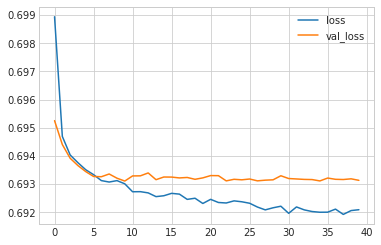

In [158]:
train_history = hist
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)